In [1]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


In [2]:
import os
import re
import numpy as np
import tensorflow as tf

In [3]:
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, 'r') as f:
    raw_corpus = f.read().splitlines()
    
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


In [8]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0 or sentence[-1] == ':':
        continue
    if idx > 9:
        break
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


## Tokenize

1. Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호

2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자

3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자

"1." 을 막기 위해 문장 부호 양쪽에 공백을 추가 할 거고요, "2." 를 막기 위해 모든 문자들을 소문자로 변환 할 겁니다. "3."을 막기 위해 특수문자들은 모두 제거 하도록 하죠!

In [15]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
#     print(sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
#     print(sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
#     print(sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
#     print(sentence)
    sentence = sentence.strip()
#     print(sentence)
    sentence = '<start> ' + sentence + ' <end>'
    return sentence
    

In [12]:
print(preprocess_sentence("This @_is ;;;sample        sentence."))

this @_is ;;;sample        sentence.
this @_is ;;;sample        sentence .
this @_is ;;;sample sentence .
this is sample sentence .
this is sample sentence .
<start> this is sample sentence . <end>


In [16]:
corpus =[]

for sentence in  raw_corpus:
    if len(sentence) == 0 or sentence[-1] == ':':
        continue
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

## Vectorize

정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환

숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다.

In [20]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 7000,
        filters = ' ',
        oov_token = "<unk>" # 7000단어에 포함되지 못한 단어는 '<unk>'
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다. post
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    
    print(tensor, tokenizer)
    return tensor, tokenizer

In [21]:
tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fcf412b8e80>


In [22]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [23]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx > 10:
        break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of
11 : you


In [24]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


In [25]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

In [26]:
dataset =  tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

## dataset 생성 과정

정규표현식을 이용한 corpus 생성

tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환

tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

## Define Model

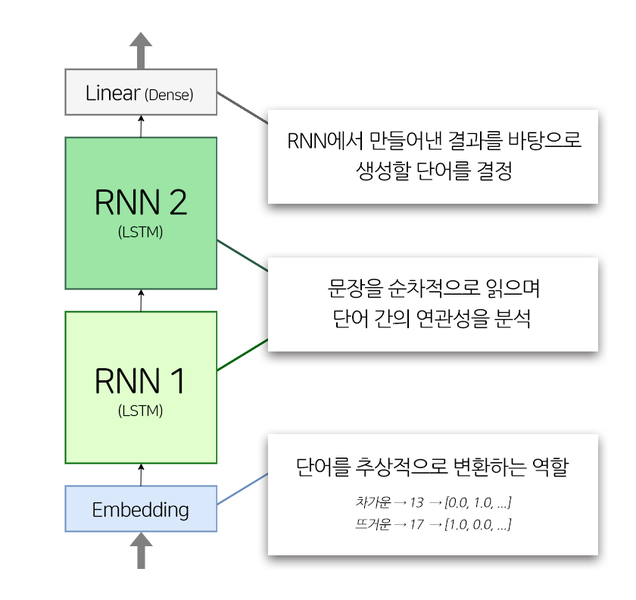

In [27]:
from tensorflow.keras.layers import *

In [30]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [31]:
embedding_size = 256
hidden_size = 1024
model = TextGenerator(VOCAB_SIZE, embedding_size, hidden_size)

embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기

hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가

In [33]:
for src_sample, tgt_sample in dataset.take(1):
    break
    
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-2.27897035e-04, -3.34012700e-04,  2.81329121e-04, ...,
          2.33594634e-04, -3.75970354e-04,  4.09709319e-04],
        [-1.51034270e-04, -7.14623660e-04,  7.27406587e-04, ...,
          3.68052599e-04, -3.30609881e-04,  3.59876169e-04],
        [-2.00827606e-04, -9.84547078e-04,  9.16168327e-04, ...,
          5.32511156e-04, -3.98105010e-04,  3.83247418e-04],
        ...,
        [-1.64599041e-03, -8.86733527e-04,  3.46346339e-03, ...,
          4.45548072e-03, -1.11994706e-03, -1.13299924e-04],
        [-1.73231435e-03, -8.28324526e-04,  3.53879202e-03, ...,
          4.85956669e-03, -1.24631671e-03, -1.77147722e-05],
        [-1.81057921e-03, -7.68781989e-04,  3.58151202e-03, ...,
          5.18796640e-03, -1.35811709e-03,  8.44456517e-05]],

       [[-2.27897035e-04, -3.34012700e-04,  2.81329121e-04, ...,
          2.33594634e-04, -3.75970354e-04,  4.09709319e-04],
        [ 4.03409285e-06, -5.76573599e-04,  5.

output shape는 입력 시퀀스의 길이에 따라 달라진다.

In [34]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [36]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none'
)

In [37]:
model.compile(loss = loss, optimizer = optimizer)

In [38]:
model.fit(dataset, epochs = 30)

Epoch 1/30
93/93 [==============================] - 22s 189ms/step - loss: 3.4646
Epoch 2/30
93/93 [==============================] - 18s 190ms/step - loss: 2.7976
Epoch 3/30
93/93 [==============================] - 17s 183ms/step - loss: 2.6876
Epoch 4/30
93/93 [==============================] - 17s 182ms/step - loss: 2.5897
Epoch 5/30
93/93 [==============================] - 17s 183ms/step - loss: 2.5293
Epoch 6/30
93/93 [==============================] - 17s 186ms/step - loss: 2.4763
Epoch 7/30
93/93 [==============================] - 17s 185ms/step - loss: 2.4185
Epoch 8/30
93/93 [==============================] - 17s 183ms/step - loss: 2.3657
Epoch 9/30
93/93 [==============================] - 17s 182ms/step - loss: 2.3148
Epoch 10/30
93/93 [==============================] - 17s 183ms/step - loss: 2.2680
Epoch 11/30
93/93 [==============================] - 17s 183ms/step - loss: 2.2179
Epoch 12/30
93/93 [==============================] - 17s 183ms/step - loss: 2.1689
Epoch 13/30
9

In [39]:
def generate_text(model, tokinizer, init_sentence = "<start>", max_len = 20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:,-1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        
        if predict_word.numpy()[0] == end_token or test_tensor.shape[1] >= max_len:
            break
            
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
        
    return generated

In [40]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a disease indeed , that you like a man . <end> '